This workload is created in kaggle. Some datasets are downloaded from kaggle.

# 1.&nbsp;Initialization

## Install necessary modules

In [1]:
!pip install onnx onnxruntime onnx2tf 
!pip install onnx_graphsurgeon
!pip install ai_edge_litert
!pip install sng4onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.2/149.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 88.0 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.0/448.0 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 107.5 MB/s eta 0:00:0000:010:01


## Import all necessary modules

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
import onnx
import onnxruntime
from onnx2tf import convert
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
from torch.nn.modules.pooling import _MaxUnpoolNd
from torch.nn.modules.utils import _pair
from torchvision.transforms.v2 import GaussianNoise
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from PIL import Image
import random
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

E0000 00:00:1749740037.288719      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749740037.341407      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Use GPU to train the model

In [3]:
my_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2.&nbsp;Data processing

## Create the new dataset and define a new collate function

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self):
        self.data = []
        self.len = 0
        for dirname, _, filenames in os.walk('/kaggle/input/salt-and-pepper-noise-images/Ground_truth'):
            for filename in filenames:
                self.data.append(Image.open(os.path.join(dirname, filename)))
                self.len += 1
        for dirname, _, filenames in os.walk('/kaggle/input/natural-images-with-synthetic-noise/train/train/ground truth'):
            for filename in filenames:
                self.data.append(Image.open(os.path.join(dirname, filename)))
                self.len += 1
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        return self.data[index]

def custom_collate(batch):
    noise_fn = GaussianNoise()
    Y = torch.zeros(0, *image_size, device=my_device)
    for item in batch:
        item = torch.zeros(1, 3, 1, 1) + pil_to_tensor(item).unsqueeze(0).float()
        Y = torch.concat([Y,item.to(my_device)])
    Y = Y / 255
    X = Y.clone()
    X = noise_fn(X)
    return X, Y

image_size = (3,512, 512)
train_dataset = CustomImageDataset()
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate)
cur_last_epoch = 0
cur_last_loss = float("inf")

# 3.&nbsp;Create the Model

## Define the Denoising AutoEncoder Model

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, channels):
        super(AutoEncoder, self).__init__()
        self.eConv11 = nn.Conv2d(3, channels, 3, padding=1)
        self.eConv12 = nn.Conv2d(channels, channels*4, 3, groups=channels, padding=1, stride=2)
        self.eConv21 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.mConv2 = nn.Conv2d(channels*4, channels*4, 3, groups=channels*4, padding=1)
        self.dConv21 = nn.Conv2d(channels*4, channels*4, 3, padding=1)
        self.dConv12 = nn.Conv2d(channels, channels, 3, groups=channels, padding=1)
        self.dConv11 = nn.Conv2d(channels, 3, 3, padding=1)
        self.relu = nn.GELU()
        self.sigmoid = nn.Sigmoid()
        self.pixel_shuffle = nn.PixelShuffle(2)
    def forward(self, X):
        X1 = self.eConv11(X)
        X1 = self.relu(X1)
        X2 = self.eConv12(X1)
        X2 = self.relu(X2)
        X2 = self.eConv21(X2)
        X2 = self.relu(X2)
        X2 = self.mConv2(X2)
        X2 = self.relu(X2)
        X2 = self.dConv21(X2)
        X2 = self.relu(X2)
        X2 = self.pixel_shuffle(X2)
        X1 = torch.add(X1,X2)
        X1 = self.dConv12(X1)
        X1 = self.relu(X1)
        X1 = self.dConv11(X1)
        X = self.sigmoid(X1)
        return X

class RMSLELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(torch.log(yhat+1),torch.log(y+1)) + self.eps)

## Experimental definition for later exporting (Do not work)

In [8]:
class MaxUnpool2dop(Function):
    """We warp the `torch.nn.functional.max_unpool2d`
    with an extra `symbolic` method, which is needed while exporting to ONNX.
    Users should not call this function directly.
    """

    @staticmethod
    def forward(ctx, input, indices, kernel_size, stride, padding,
                output_size):
        """Forward function of MaxUnpool2dop.
        Args:
            input (Tensor): Tensor needed to upsample.
            indices (Tensor): Indices output of the previous MaxPool.
            kernel_size (Tuple): Size of the max pooling window.
            stride (Tuple): Stride of the max pooling window.
            padding (Tuple): Padding that was added to the input.
            output_size (List or Tuple): The shape of output tensor.
        Returns:
            Tensor: Output tensor.
        """
        return F.max_unpool2d(input, indices, kernel_size, stride, padding,
                              output_size)

    @staticmethod
    def symbolic(g, input, indices, kernel_size, stride, padding, output_size):
        # get shape
        input_shape = g.op('Shape', input)
        const_0 = g.op('Constant', value_t=torch.tensor(0))
        const_1 = g.op('Constant', value_t=torch.tensor(1))
        batch_size = g.op('Gather', input_shape, const_0, axis_i=0)
        channel = g.op('Gather', input_shape, const_1, axis_i=0)

        # height = (height - 1) * stride + kernel_size
        height = g.op(
            'Gather',
            input_shape,
            g.op('Constant', value_t=torch.tensor(2)),
            axis_i=0)
        height = g.op('Sub', height, const_1)
        height = g.op('Mul', height,
                      g.op('Constant', value_t=torch.tensor(stride[1])))
        height = g.op('Add', height,
                      g.op('Constant', value_t=torch.tensor(kernel_size[1])))

        # width = (width - 1) * stride + kernel_size
        width = g.op(
            'Gather',
            input_shape,
            g.op('Constant', value_t=torch.tensor(3)),
            axis_i=0)
        width = g.op('Sub', width, const_1)
        width = g.op('Mul', width,
                     g.op('Constant', value_t=torch.tensor(stride[0])))
        width = g.op('Add', width,
                     g.op('Constant', value_t=torch.tensor(kernel_size[0])))

        # step of channel
        channel_step = g.op('Mul', height, width)
        # step of batch
        batch_step = g.op('Mul', channel_step, channel)

        # channel offset
        range_channel = g.op('Range', const_0, channel, const_1)
        range_channel = g.op(
            'Reshape', range_channel,
            g.op('Constant', value_t=torch.tensor([1, -1, 1, 1])))
        range_channel = g.op('Mul', range_channel, channel_step)
        range_channel = g.op('Cast', range_channel, to_i=7)  # 7 is int64

        # batch offset
        range_batch = g.op('Range', const_0, batch_size, const_1)
        range_batch = g.op(
            'Reshape', range_batch,
            g.op('Constant', value_t=torch.tensor([-1, 1, 1, 1])))
        range_batch = g.op('Mul', range_batch, batch_step)
        range_batch = g.op('Cast', range_batch, to_i=7)  # 7 is int64

        # update indices
        indices = g.op('Add', indices, range_channel)
        indices = g.op('Add', indices, range_batch)

        return g.op(
            'MaxUnpool',
            input,
            indices,
            kernel_shape_i=kernel_size,
            strides_i=stride)


class MaxUnpool2d(_MaxUnpoolNd):
    """This module is modified from Pytorch `MaxUnpool2d` module.
    Args:
      kernel_size (int or tuple): Size of the max pooling window.
      stride (int or tuple): Stride of the max pooling window.
          Default: None (It is set to `kernel_size` by default).
      padding (int or tuple): Padding that is added to the input.
          Default: 0.
    """

    def __init__(self, kernel_size, stride=None, padding=0):
        super(MaxUnpool2d, self).__init__()
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride or kernel_size)
        self.padding = _pair(padding)

    def forward(self, input, indices, output_size=None):
        """Forward function of MaxUnpool2d.
        Args:
            input (Tensor): Tensor needed to upsample.
            indices (Tensor): Indices output of the previous MaxPool.
            output_size (List or Tuple): The shape of output tensor.
                Default: None.
        Returns:
            Tensor: Output tensor.
        """
        return MaxUnpool2dop.apply(input, indices, self.kernel_size,
                                   self.stride, self.padding, output_size)

## Create the model and define some hyperparameters

In [9]:
model = AutoEncoder(16)
loss_fn = RMSLELoss()
optim = torch.optim.AdamW(model.parameters(), weight_decay=1e-5)
num_params = sum(param.numel() for param in model.parameters())
num_params

76179

## Training

Result:
Epoch 1 	 Loss: 0.056350
Epoch 2 	 Loss: 0.029715
Epoch 3 	 Loss: 0.026532
Epoch 4 	 Loss: 0.024476
Epoch 5 	 Loss: 0.023292
Epoch 6 	 Loss: 0.022610
Epoch 7 	 Loss: 0.022108
Epoch 8 	 Loss: 0.021732
Epoch 9 	 Loss: 0.021426
Epoch 10 	 Loss: 0.021207
Epoch 11 	 Loss: 0.021022
Epoch 12 	 Loss: 0.020809
Epoch 13 	 Loss: 0.020654
Epoch 14 	 Loss: 0.020494
Epoch 15 	 Loss: 0.020341
Epoch 16 	 Loss: 0.020231
Epoch 17 	 Loss: 0.020104
Epoch 18 	 Loss: 0.019993
Epoch 19 	 Loss: 0.019904
Epoch 20 	 Loss: 0.019782
Previous Result: Epoches: 0 	 Loss: inf
Current Result:  Epoches: 20 	 Loss: 0.019782


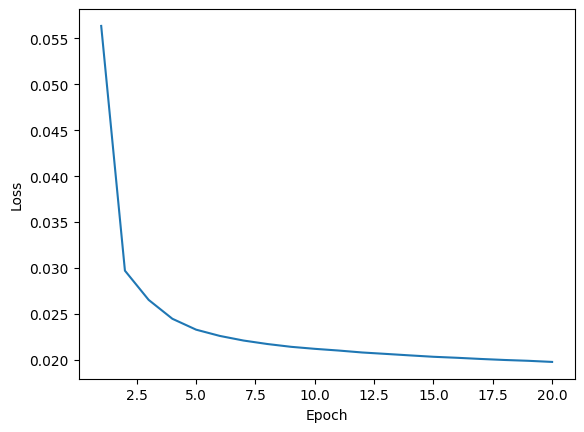

In [10]:
def train_loop(dataloader, model, loss_fn, optim, cur_epoch):
    model.train()
    info = []
    acc_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        acc_loss += loss.item()
        optim.step()
        optim.zero_grad()
    cur_epoch += 1
    info.append({"epoch": cur_epoch, "loss": acc_loss/batch})
    print(f"Epoch {cur_epoch} \t Loss: {acc_loss/batch:.6f}")
    return info, cur_epoch

def eval_model_performance(train_dataloader, model, loss_fn, optim, epoches, last_record):
    cur_epoch = 0
    train_info = []
    for i in range(epoches):
        info, cur_epoch = train_loop(train_dataloader, model, loss_fn, optim, cur_epoch)
        train_info += info
    print(f"Previous Result: Epoches: {last_record[0]} \t Loss: {last_record[1]:.6f}")
    last_record = (train_info[len(train_info)-1]["epoch"],train_info[len(train_info)-1]["loss"])
    print(f"Current Result:  Epoches: {last_record[0]} \t Loss: {last_record[1]:.6f}")
    plt.plot(torch.tensor([info["epoch"] for info in train_info], device='cpu'), torch.tensor([info["loss"] for info in train_info], device='cpu'))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    return last_record

model.to(device="cuda")
print("Result:")
(cur_last_epoch, cur_last_loss) = eval_model_performance(train_dataloader, model, loss_fn, optim, 20, (cur_last_epoch, cur_last_loss))

## Evaluate the model by visualizing the performance in pyplot

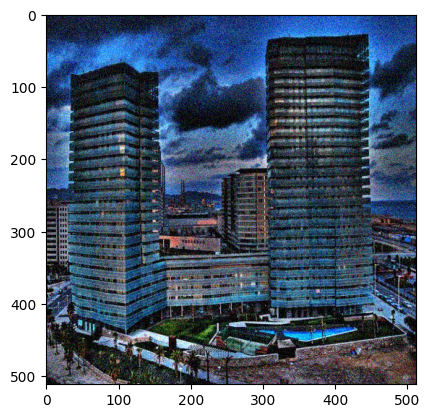

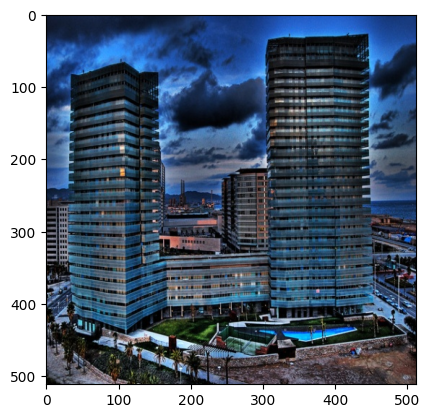

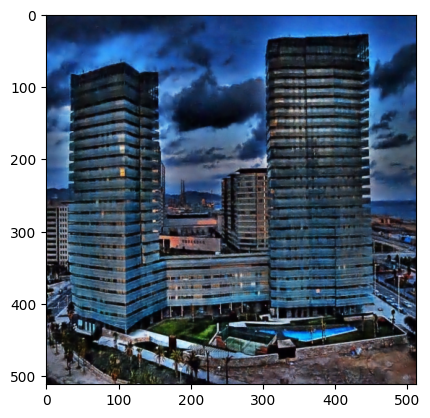

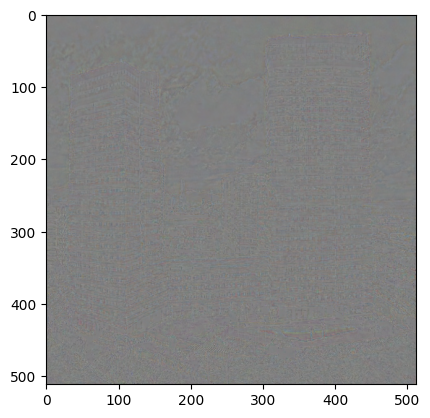

In [11]:
model.to(device="cpu")
model.eval()
inp, out = custom_collate([train_dataset[8]])
inp, out = inp.cpu(), out.cpu()
X_out = model(inp)
plt.imshow(to_pil_image((inp[0] * 255).byte()))
plt.show()
plt.imshow(to_pil_image((out[0] * 255).byte()))
plt.show()
plt.imshow(to_pil_image((X_out[0] * 255).byte()))
plt.show()
plt.imshow(to_pil_image(((X_out[0]-out[0]+1)/2 * 255).byte()))
plt.show()

# 4.&nbsp;Converting the PyTorch model into ONNX model

## Export the model as ONNX Model

In [12]:
inp, out = custom_collate([train_dataset[8]])
inp, out = inp.cpu(), out.cpu()
x = torch.randn(1, *image_size, requires_grad=True)
torch_out = model(inp)
torch.onnx.export(
    model,           # model being run
    inp,                         # model input (or a tuple for multiple inputs)
    "denoising_autoencoder.onnx",   # where to save the model (can be a file or file-like object)
    export_params = True,        # store the trained parameter weights inside the model file
    opset_version = 10,          # the ONNX version to export the model to
    do_constant_folding = True,  # whether to execute constant folding for optimization
    input_names = ['input'],   # the model's input names
    output_names = ['output'], # the model's output names
    dynamic_axes = {'input' : {0 : 'batch_size'},    # variable length axes
                    'output' : {0 : 'batch_size'}})

## Load the model to check for correct converting

In [13]:
onnx_model = onnx.load("/kaggle/working/denoising_autoencoder.onnx")
onnx.checker.check_model(onnx_model)

## Check if both PyTorch model and ONNX model produce around the same result

In [ ]:
ort_session = onnxruntime.InferenceSession("/kaggle/working/denoising_autoencoder.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(inp)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

plt.imshow(np.transpose(to_numpy(torch_out)[0], (1,2,0)))
plt.show()
plt.imshow(np.transpose(ort_outs[0][0], (1,2,0)))
plt.show()
plt.imshow(np.transpose(to_numpy(torch_out)[0]-ort_outs[0][0]+1, (1,2,0))/2)
plt.show()

# 5.&nbsp;Convert the ONNX model into TensorFlow model

## Converting and check for similar performance


Model optimizing started ============================================================
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/onnx2tf/onnx2tf.py", line 668, in convert
    result = subprocess.check_output(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 466, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.11/subprocess.py", line 1955, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'onnxsim'


Automatic generatio

I0000 00:00:1749740770.136340      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14277 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


INFO: tf_op_type: divide
INFO:  input.1.x: name: tf.math.add_4/Add:0 shape: (None, 256, 256, 64) dtype: <dtype: 'float32'> 
INFO:  input.2.y: shape: () dtype: <dtype: 'float32'> 
INFO:  output.1.output: name: tf.math.divide_1/truediv:0 shape: (None, 256, 256, 64) dtype: <dtype: 'float32'> 

INFO: 30 / 63
INFO: onnx_op_type: Erf onnx_op_name: /relu_1/Erf
INFO:  input_name.1: /relu_1/Div_output_0 shape: ['batch_size', 64, 256, 256] dtype: float32
INFO:  output_name.1: /relu_1/Erf_output_0 shape: ['batch_size', 64, 256, 256] dtype: float32
INFO: tf_op_type: erf
INFO:  input.1.x: name: tf.math.divide_1/truediv:0 shape: (None, 256, 256, 64) dtype: <dtype: 'float32'> 
INFO:  output.1.output: name: tf.math.erf_1/Erf:0 shape: (None, 256, 256, 64) dtype: <dtype: 'float32'> 

INFO: 31 / 63
INFO: onnx_op_type: Add onnx_op_name: /relu_1/Add
INFO:  input_name.1: /relu_1/Erf_output_0 shape: ['batch_size', 64, 256, 256] dtype: float32
INFO:  input_name.2: /relu_1/Constant_1_output_0 shape: [] dtype: 

I0000 00:00:1749740772.551209      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749740772.551440      35 single_machine.cc:361] Starting new session
I0000 00:00:1749740772.552584      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14277 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
W0000 00:00:1749740772.731675      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749740772.731704      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Float32 tflite output complete!


I0000 00:00:1749740772.970650      35 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
I0000 00:00:1749740772.970793      35 single_machine.cc:361] Starting new session
I0000 00:00:1749740772.971800      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14277 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
W0000 00:00:1749740773.119815      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1749740773.119843      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1749740773.275552      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


Float16 tflite output complete!


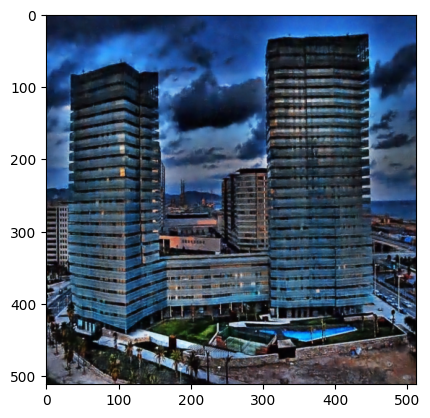

In [16]:
tf_model = convert("/kaggle/working/denoising_autoencoder.onnx")
tf_pred = tf_model(np.transpose(to_numpy(inp),(0,2,3,1)))
plt.imshow(tf_pred[0])
plt.show()

## Save the Tensorflow Model in .h5 format

In [17]:
tf_model.save("denoising_autoencoder.h5",save_format='h5')

### The Tensorflow model will later be converted into TensorFlow.js model using tensorflowjs_converter.